<a href="https://colab.research.google.com/github/Satyam1Gupta/Sentiment-Analysis-LSTM/blob/main/SentimentAnalysis_with_WordToVec_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting the environment

In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


## Loading dataset

In [ ]:

twitter_data = pd.read_excel("/content/Final_balanced_sentiment_data.xlsx")

twitter_data

,text,sentiment
0,what did just say vote for modi welcome bjp t...,1
1,asking his supporters prefix chowkidar their n...,1
2,answer who among these the most powerful world...,1
3,with upcoming election india saga going import...,1
4,gandhi was gay does modi,1
...,...,...
131356,what modi saying against democracy should flee...,0
131357,niti aayog accessory for the modi government m...,0
131358,mrjairam here answer lies bjp godi media many ...,0
131359,india prime ministerasaduddin owaisi slams mod...,0


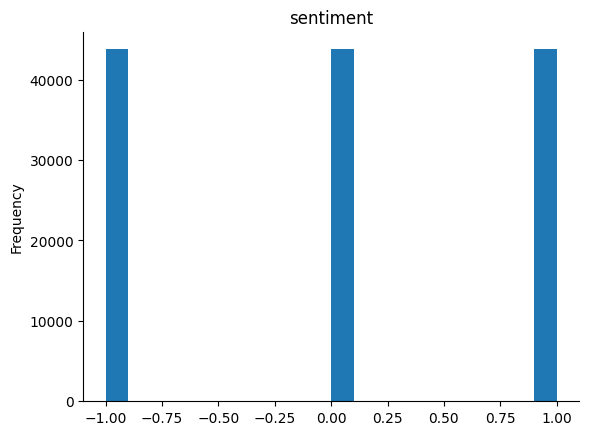

In [ ]:
from matplotlib import pyplot as plt
twitter_data['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Dataset exploration

twitter_data.shape

(131361, 2)

In [ ]:
twitter_data.head(5)

,text,sentiment
0,what did just say vote for modi welcome bjp t...,1
1,asking his supporters prefix chowkidar their n...,1
2,answer who among these the most powerful world...,1
3,with upcoming election india saga going import...,1
4,gandhi was gay does modi,1


In [ ]:
# Checking for missing values

twitter_data.isnull().values.sum()

2

In [ ]:
# Delete rows with any null values
twitter_data = twitter_data.dropna()

# Verify that there are no missing values left
missing_values_cleaned = twitter_data.isnull().sum()
print(missing_values_cleaned)

text         0
sentiment    0
dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

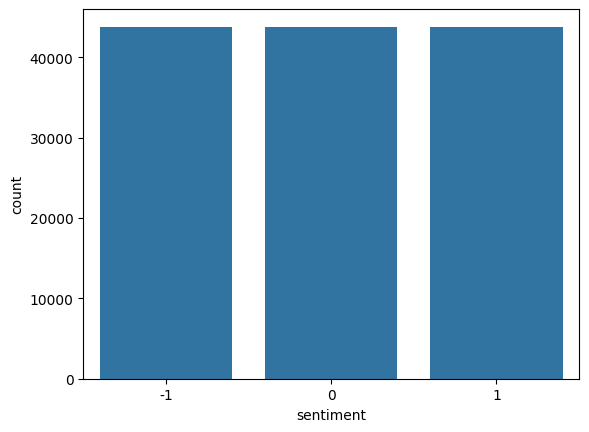

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=twitter_data)

## Data Preprocessing

In [ ]:
twitter_data["text"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'answer who among these the most powerful world leader today trump putin modi may '

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence=sen
    # sentence = sen.lower()

    # # Remove html tags
    # sentence = remove_tags(sentence)

    # # Remove punctuations and numbers
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on twitter_data

X = []
sentences = list(twitter_data['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'answer among powerful world leader today trump putin modi may '

In [ ]:
# Converting sentiment labels to 0 & 1

y = twitter_data['sentiment']

# y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

*Embedding* layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

88154

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# prompt: Donwlnload word to vec word embeddings to create an embeddign dict.
import gensim.downloader as api

# Download the word2vec model
model = api.load("word2vec-google-news-300")

# Create an embedding dict
embedding_dict = {}
# Iterate directly over the model's vocabulary and vectors
for word in model.key_to_index:
    embedding_dict[word] = model[word]


In [ ]:
# prompt: print the size and first 5 data of embedding dict

print("Size of embedding_dict:", len(embedding_dict))
print("First 5 data of embedding_dict:")
for i in range(5):
    print(list(embedding_dict.items())[i])
# size of each row =300

Size of embedding_dict: 3000000
First 5 data of embedding_dict:
('</s>', array([ 1.1291504e-03, -8.9645386e-04,  3.1852722e-04,  1.5335083e-03,
        1.1062622e-03, -1.4038086e-03, -3.0517578e-05, -4.1961670e-04,
       -5.7601929e-04,  1.0757446e-03, -1.0223389e-03, -6.1798096e-04,
       -7.5531006e-04,  1.4038086e-03, -1.6403198e-03, -6.3323975e-04,
        1.6326904e-03, -1.0070801e-03, -1.2664795e-03,  6.5231323e-04,
       -4.1580200e-04, -1.0757446e-03,  1.5258789e-03, -2.7465820e-04,
        1.4019012e-04,  1.5716553e-03,  1.3580322e-03, -8.3160400e-04,
       -1.4038086e-03,  1.5792847e-03,  2.5367737e-04, -7.3242188e-04,
       -1.0538101e-04, -1.1672974e-03,  1.5792847e-03,  6.5612793e-04,
       -6.5994263e-04,  2.9206276e-06,  1.1291504e-03,  4.2724609e-04,
       -3.7002563e-04, -1.1520386e-03,  1.2664795e-03, -3.5166740e-06,
        2.6512146e-04, -4.0245056e-04,  1.4114380e-04, -3.3617020e-05,
        7.5912476e-04, -5.1879883e-04, -7.1048737e-05,  6.0272217e-04,
    

In [ ]:
#  Instead of using Glove as word embedding here use the word to vec as the word embeddign

import numpy as np
import gensim
from gensim.models import Word2Vec

# Create Embedding Matrix having 100 columns
# Containing 100-dimensional wordtovec word embeddings for all words in our corpus.

embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
#  Donwlnload Glove word embeddings to create an embeddign dict.

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip


In [ ]:
# # Load GloVe word embeddings and create an Embeddings Dictionary

# from numpy import asarray
# from numpy import zeros

# embeddings_dictionary = dict()
# glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary [word] = vector_dimensions
# glove_file.close()

In [ ]:
# # Create Embedding Matrix having 100 columns
# # Containing 100-dimensional GloVe word embeddings for all words in our corpus.

# embedding_matrix = zeros((vocab_length, 100))
# for word, index in word_tokenizer.word_index.items():
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(88154, 300)

# Model Training with:

## Simple Neural Network

In [ ]:
# Neural Network architecture

# snn_model = Sequential()
# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# snn_model.add(embedding_layer)

# snn_model.add(Flatten())
# snn_model.add(Dense(1, activation='sigmoid'))
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(3, activation='softmax'))  # 3 output nodes for 3 classes


In [ ]:
# Model compiling

# snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

snn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(snn_model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          26446200  
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 3)                 90003     
                                                                 
Total params: 26536203 (101.23 MB)
Trainable params: 90003 (351.57 KB)
Non-trainable params: 26446200 (100.88 MB)
_________________________________________________________________
None


In [ ]:

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("Corrected Shapes:")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Corrected Shapes:
y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 19s 27ms/step - loss: 0.8627 - accuracy: 0.6113 - val_loss: 0.8177 - val_accuracy: 0.6408
Epoch 2/6
657/657 [==============================] - 13s 19ms/step - loss: 0.7603 - accuracy: 0.6734 - val_loss: 0.7985 - val_accuracy: 0.6531
Epoch 3/6
657/657 [==============================] - 14s 22ms/step - loss: 0.7229 - accuracy: 0.6941 - val_loss: 0.7922 - val_accuracy: 0.6556
Epoch 4/6
657/657 [==============================] - 15s 23ms/step - loss: 0.7008 - accuracy: 0.7067 - val_loss: 0.7900 - val_accuracy: 0.6594
Epoch 5/6
657/657 [==============================] - 14s 21ms/step - loss: 0.6862 - accuracy: 0.7132 - val_loss: 0.7954 - val_accuracy: 0.6570
Epoch 6/6
657/657 [==============================] - 17s 26ms/step - loss: 0.6748 - accuracy: 0.7189 - val_loss: 0.8001 - val_accuracy: 0.6592


In [ ]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 4s 5ms/step - loss: 0.7939 - accuracy: 0.6651


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7938565015792847
Test Accuracy: 0.6651187539100647


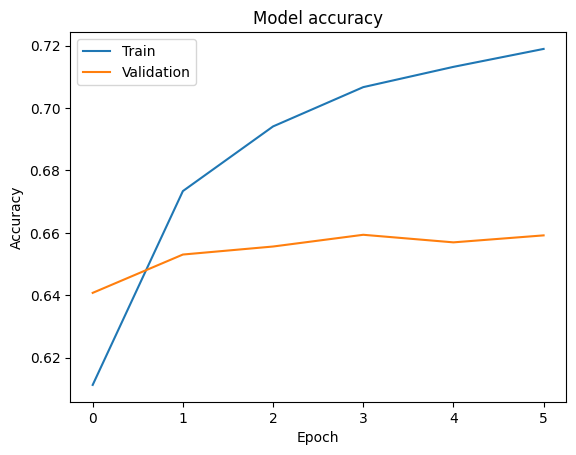

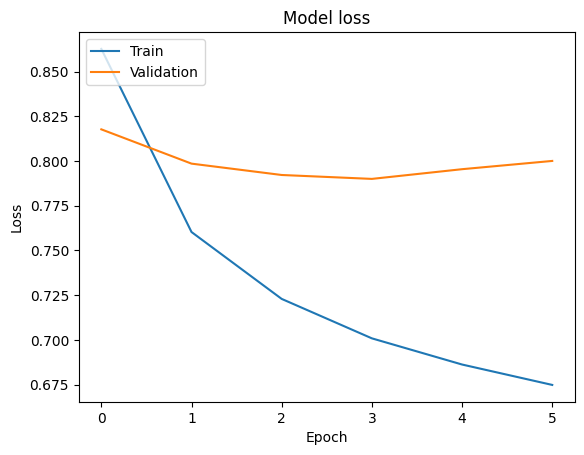

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(snn_model_history.history['accuracy'])
plt.plot(snn_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Convolutional Neural Network

In [ ]:
from keras.layers import Conv1D

In [ ]:
# # Neural Network architecture

# cnn_model = Sequential()

# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# cnn_model.add(embedding_layer)

# cnn_model.add(Conv1D(128, 5, activation='relu'))
# cnn_model.add(GlobalMaxPooling1D())
# cnn_model.add(Dense(1, activation='sigmoid'))


# Define the model
cnn_model = Sequential()

# Embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

# Convolutional layer
cnn_model.add(Conv1D(128, 5, activation='relu'))

# Global max pooling layer
cnn_model.add(GlobalMaxPooling1D())

# Output layer for 3 classes
cnn_model.add(Dense(3, activation='softmax'))  # 3 output units for 3 classes, softmax for multi-class classification

In [ ]:
# Model compiling

# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(cnn_model.summary())


cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],run_eagerly=True)

# Print model summary
print(cnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          26446200  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 26638715 (101.62 MB)
Trainable params: 192515 (752.01 KB)
Non-trainable params: 26446200 (100.88 MB)
_________________________________________________________________
None


In [ ]:
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 328s 500ms/step - loss: 0.0887 - accuracy: 0.9828 - val_loss: 0.5325 - val_accuracy: 0.8323
Epoch 2/6
657/657 [==============================] - 295s 448ms/step - loss: 0.0642 - accuracy: 0.9891 - val_loss: 0.5632 - val_accuracy: 0.8335
Epoch 3/6
657/657 [==============================] - 295s 449ms/step - loss: 0.0465 - accuracy: 0.9931 - val_loss: 0.5941 - val_accuracy: 0.8327
Epoch 4/6
657/657 [==============================] - 294s 448ms/step - loss: 0.0345 - accuracy: 0.9956 - val_loss: 0.6258 - val_accuracy: 0.8291
Epoch 5/6
657/657 [==============================] - 291s 443ms/step - loss: 0.0275 - accuracy: 0.9965 - val_loss: 0.6642 - val_accuracy: 0.8309
Epoch 6/6
657/657 [==============================] - 296s 451ms/step - loss: 0.0239 - accuracy: 0.9965 - val_loss: 0.7128 - val_accuracy: 0.8218


In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 36s 44ms/step - loss: 0.6964 - accuracy: 0.8261


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.69640052318573
Test Accuracy: 0.8261266946792603


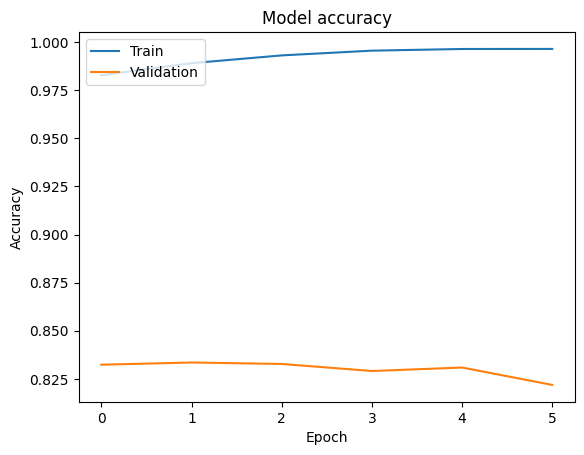

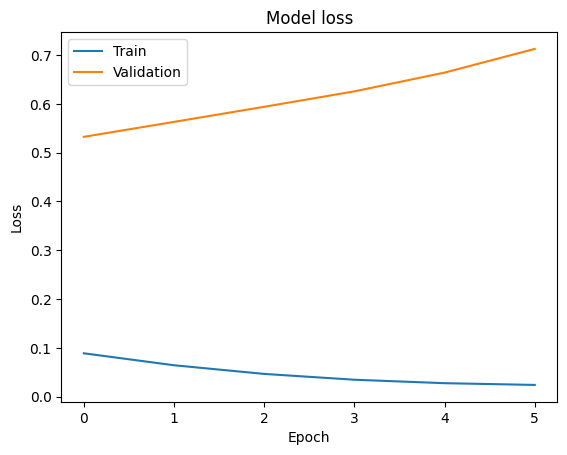

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(3, activation='softmax'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          26446200  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 26666235 (101.72 MB)
Trainable params: 220035 (859.51 KB)
Non-trainable params: 26446200 (100.88 MB)
_________________________________________________________________
None


In [ ]:
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [53]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 298s 449ms/step - loss: 0.6365 - acc: 0.3395 - val_loss: 0.6348 - val_acc: 0.3297
Epoch 2/6
657/657 [==============================] - 293s 446ms/step - loss: 0.5050 - acc: 0.5954 - val_loss: 0.4223 - val_acc: 0.7059
Epoch 3/6
657/657 [==============================] - 291s 443ms/step - loss: 0.3778 - acc: 0.7471 - val_loss: 0.3495 - val_acc: 0.7711
Epoch 4/6
657/657 [==============================] - 277s 421ms/step - loss: 0.3279 - acc: 0.7904 - val_loss: 0.3140 - val_acc: 0.8043
Epoch 5/6
657/657 [==============================] - 292s 444ms/step - loss: 0.2917 - acc: 0.8204 - val_loss: 0.2854 - val_acc: 0.8287
Epoch 6/6
657/657 [==============================] - 291s 444ms/step - loss: 0.2556 - acc: 0.8501 - val_loss: 0.2584 - val_acc: 0.8512


In [54]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 59s 72ms/step - loss: 0.2556 - acc: 0.8525


In [55]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.25561681389808655
Test Accuracy: 0.8524665236473083


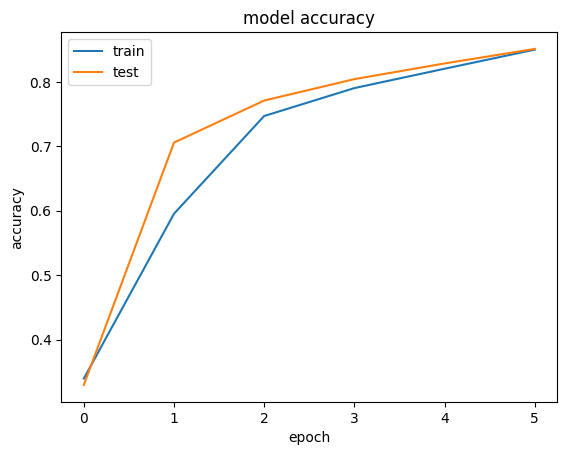

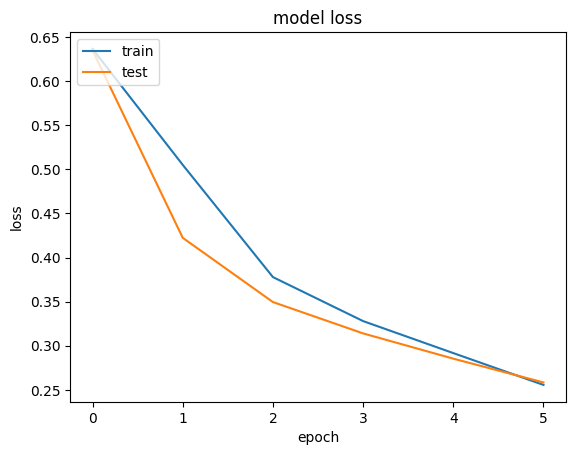

In [56]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()